In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cv2
from tqdm import tqdm

In [3]:
with open(f'./kmeans_coords.pckl','rb') as f:
    coords = pickle.load(f)

with open(f'./kmeans_fnames.pckl','rb') as f:
    fnames = pickle.load(f)

In [4]:
train_i = {}
test_i = {}

train_xy = pd.read_csv('train.csv')
train_path = train_xy['id'].values
test_path = pd.read_csv('imagenames.csv')['id'].values

for f in train_path:
    i = cv2.imread('./train/' + f + '.jpg')
    train_i[f] = i
for f in test_path:
    i = cv2.imread('./test/' + f + '.jpg')
    test_i[f] = i

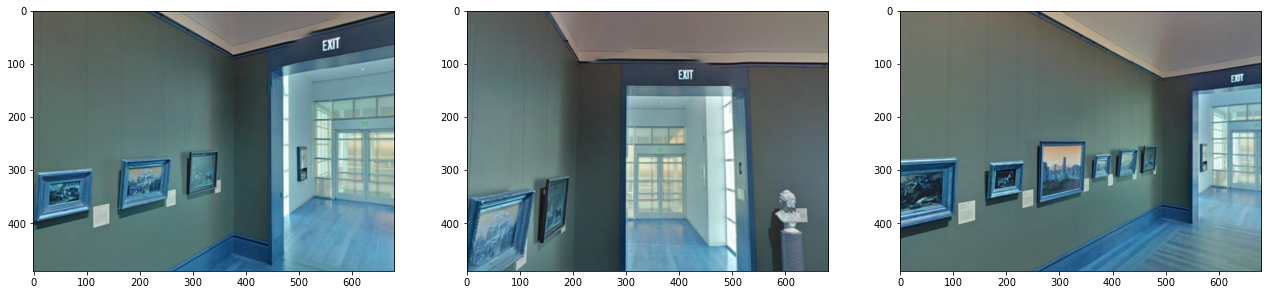

In [124]:
_,ax = plt.subplots(1,3,figsize=(22,6))
ax[0].imshow(train_i['IMG3375_4'])
ax[1].imshow(train_i['IMG3985_2'])
ax[2].imshow(train_i['IMG3473_3'])

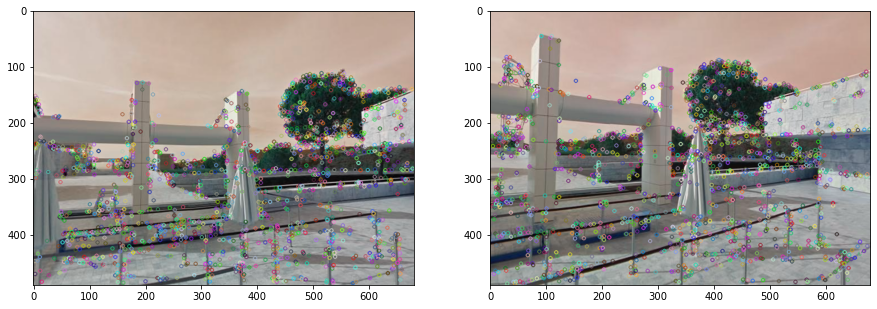

In [266]:
#img = train_i['IMG3375_4']
#img = train_i['IMG3018_5']
img = train_i['IMG3093_5']
img2 = train_i['IMG3522_4']
#img2 = train_i['IMG3473_3']
#img2 = train_i['IMG3985_2']

sift = cv2.SIFT_create()

kp,des = sift.detectAndCompute(img,None)
kp_draw = cv2.drawKeypoints(img,kp,None)

kp2,des2 = sift.detectAndCompute(img2,None)
kp_draw2 = cv2.drawKeypoints(img2,kp2,None)

_,ax = plt.subplots(1,2,figsize=(15,6))
ax[0].imshow(kp_draw)
ax[1].imshow(kp_draw2)


Number of successful matches between two images:  44


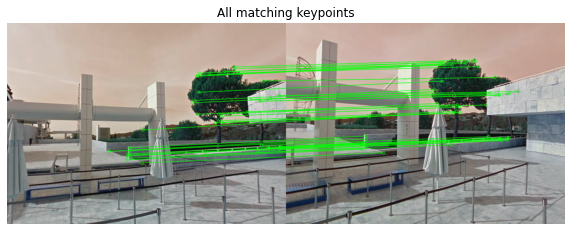

(-0.5, 999.5, 599.5, -0.5)

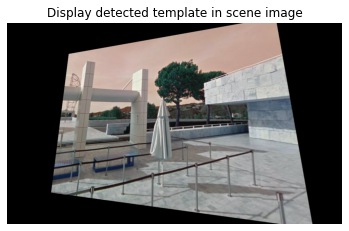

In [273]:
# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des,des2,k=2)

# Store all good matches as per Lowe's Ratio test.
ratio = 0.6
good = []
for m,n in matches:
    if m.distance < ratio*n.distance:
        good.append(m)

# Set a condition that at least MIN_MATCH_NUM matches are required to find the object. 
MIN_MATCH_NUM = 4

if len(good)> MIN_MATCH_NUM:
    # If enough matches are found, we extract the positions of the matched keypoints in both images. 
    # They are passed to find the perspective transformation. 
    
    # Estimate homography between two images
    ptsA = np.float32([kp[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, status = cv2.findHomography(ptsA, 
                                   ptsB, 
                                   cv2.RANSAC, 
                                   ransacReprojThreshold = 25, 
                                   maxIters = 500)

    matchesMask = status.ravel().tolist()
    # Draw detected template in scene image
    imgOut = cv2.warpPerspective(img2, H, (1000,600),
                             flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    
    # Print total number of successful matches between two images
    print("\nNumber of successful matches between two images: ", matchesMask.count(1))

# Draw our inliers (if successfully found the object) or all matching keypoints (if failed)
draw_params = dict(matchColor = (0,255,0), # draw in a specific colour
                   singlePointColor = (255,0,0), # draw in a specific colour
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

success_matches = cv2.drawMatches(img,kp,img2,kp2,good,None,**draw_params)


# Plotting results
plt.subplots(figsize=(10, 10)) 

plt.imshow(success_matches)
plt.title('All matching keypoints')
plt.axis('off')
plt.show()

plt.imshow(imgOut, 'gray')
plt.title('Display detected template in scene image')
plt.axis('off')

In [268]:
pt1 = train_xy.loc[train_xy['id']=='IMG3093_5',['x','y']].values
pt2 = train_xy.loc[train_xy['id']=='IMG3522_4',['x','y']].values
print(pt1,pt2)
pt1-pt2

[[-91.48067808 133.5827196 ]] [[-92.38067808 131.5827196 ]]


array([[0.9, 2. ]])

In [223]:
H

array([[ 3.26449875e+00,  4.17134188e-03, -9.39780317e+02],
       [ 6.84563816e-01,  2.48255226e+00, -3.91845686e+02],
       [ 2.73829549e-03, -6.06071331e-07,  1.00000000e+00]])

In [274]:
FOV_X = 73.3*np.pi/180
FOV_Y = 53.1*np.pi/180

cx = img.shape[1]/2
cy = img.shape[0]/2

fx = cx/np.tan(FOV_X/2)
fy = cy/np.tan(FOV_Y/2)

K = np.array([[fx,0,cx],
              [0,fy,cy],
              [0,0,1]])

Es,_ = cv2.findEssentialMat(ptsA,ptsB,K,method=cv2.FM_LMEDS)
_,_,Ts = cv2.decomposeEssentialMat(Es)
Ts

array([[-0.91392381],
       [-0.02557752],
       [ 0.40507908]])